In [0]:
import sys
sys.path.append('drive/My Drive/Winter 2020/NLP/NLP_project/Project_2/step_3/')

In [2]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=ea62045d2e6de3e2266f5313352582430e599448f897d00e9ae3c29e84034a6a
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
your_module = drive.CreateFile({'id':'18Da5CqOXYG5pUlG4oya1ANjukNfqJtwB'})
your_module.GetContentFile('step_1.ipynb')

importing Jupyter notebook from step_1.ipynb
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
(30, 672904)
done


1.15.0
Train data lenght: 20067618
(30, 166667)
(30, 8279)
(30, 8270)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0  Training loss: 854067.338176012   Validation loss: 41144.33496403694   Testing loss: 40789.388758182526   Training perplexity: 168.0825577049328   Validation perplexity: 144.15997774563908   Test perplexity: 138.8514341672636  Time: 791.0769352912903
Epoch: 1  Training loss: 795089.1294287443   Validation loss: 39840.04319143295   Testing loss: 39468.172420978546   Training perplexity: 117.98794785145797   Validation perplexity: 123.1426431997043   Test perplexity: 118.34519789389208  Time: 794.001969575882
Epoch: 2  Training loss: 770612.0305755138   Validation loss: 39158.76564967632   Testing loss: 38785.76156556606   Training perplexity: 101.87213216501057   Validation perplexity: 113.41273261431874   Test perplexity: 108.96964658401212  Time: 794.5224556922913
Epoch: 3  Training loss: 754413.6183730364   Validation loss: 38729.10

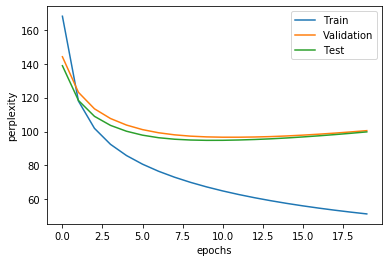

In [6]:
import numpy as np
from step_1 import load_pickle
# from step_1 import save_pickle
import warnings
from step_1 import create_batches
import math
from tqdm import tqdm
import time
import matplotlib.pyplot as plt


with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import tensorflow as tf
    print(tf.__version__)


class Parameters():
    def __init__(self, V, n_train, n_valid, n_test):
        self.window_size = 2
        self.n_nodes_hl = 100
        self.n_dimensions = 100
        self.alpha = 0.003
        self.n_batches = 30
        self.batch_size = math.ceil(n_train / self.n_batches)
        self.batch_size_valid = math.ceil(n_valid / self.n_batches)
        self.batch_size_test = math.ceil(n_test / self.n_batches)
        self.in_size = [self.n_batches, self.window_size * self.n_dimensions]  #no of batches = 668921
        self.V = V
        self.out_size = [self.n_batches, V]
        self.n_epochs = 20
        self.r = 0.1


class BengioModel:
    def __init__(self, params):
        self.x = tf.compat.v1.placeholder(tf.int32, shape=[params.n_batches, params.window_size], name="x")
        self.y = tf.compat.v1.placeholder(tf.int32, shape=[params.n_batches], name="y")
        self.alpha = tf.compat.v1.placeholder(tf.float32, shape=[1], name="alpha")
        with tf.compat.v1.variable_scope("foo", reuse = tf.AUTO_REUSE) as scope:
            self.C = tf.compat.v1.get_variable("C", [params.V, params.n_dimensions], tf.float32)
            # self.W = tf.compat.v1.get_variable("W", [params.window_size * params.n_dimensions, params.V], tf.float32)
            self.H = tf.compat.v1.get_variable("H", [params.window_size * params.n_dimensions, params.n_nodes_hl], tf.float32)
            self.d = tf.compat.v1.get_variable("d", [1, params.n_nodes_hl], tf.float32)
            self.U = tf.compat.v1.get_variable("U", [params.n_nodes_hl, params.V], tf.float32)
            # self.b = tf.compat.v1.get_variable("b", [1, params.V], tf.float32)

    def forward(self, x):
        x_embedded = tf.reshape(tf.nn.embedding_lookup(self.C, x), params.in_size)
        # x_embedded = tf.reshape(tf.nn.embedding_lookup(self.C, x), params.in_size)
        a1 = tf.matmul(tf.tanh(tf.add(self.d, (tf.matmul(x_embedded, self.H)))), self.U)
        # direct = tf.add(tf.add(tf.matmul(x_embedded, self.W), self.b), a1)
        # yhat = tf.nn.softmax(a1)
        return a1
        # return tf.math.reduce_max(yhat, axis = 1)
        # for i in y:
        #   vocalb_dict[y]
    
    def compute_loss(self, logits, y,vocab_size):
      y_labels = tf.one_hot(y, vocab_size, name='y_label')
      self.loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_labels, logits=logits)

    def perform_optimization(self, alpha, loss):
      self.optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)


def run_model(data, valid_data, test_data, model, running_mode):


    if running_mode == 'train':
        train_data = create_batches(data, params.n_batches)
        valid_data = create_batches(valid_data, params.n_batches)
        test_data = create_batches(test_data, params.n_batches)


        logits = model.forward(model.x)
        model.compute_loss(logits, model.y, params.V)
        model.perform_optimization(params.alpha, model.loss)
        
        # yhat = model.forward(model.x)
        # y_hat = tf.convert_to_tensor([yhat[_, tf.cast(model.y[_], tf.int32)] for _ in range(params.n_batches)])
        # cost = -tf.math.divide(tf.math.reduce_sum(tf.math.log(y_hat)), params.n_batches)
        # optimizer = tf.train.GradientDescentOptimizer(params.alpha).minimize(cost)
        
        # y_np = np.empty((params.n_batches, 0))
        # y_np_valid = np.empty((params.n_batches, 0))
        perplexity = []
        perplexity_valid = []
        perplexity_test = []
        saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            for epoch in range(params.n_epochs):
                start = time.time()

                y_np, y_np_valid, y_np_test = [], [], []
                epoch_loss, epoch_loss_valid, epoch_loss_test = 0, 0, 0

                # Train
                for i in range(params.batch_size - params.window_size):
                    x = train_data[:, i: i+params.window_size]
                    y = train_data[:, i+params.window_size]
                    _, c = sess.run([model.optimizer, model.loss], feed_dict={model.x: x, model.y: y})
                    epoch_loss += np.mean(c)
                perplexity.append(math.exp(epoch_loss/(params.batch_size - params.window_size)))

                # Validate
                for i in range(params.batch_size_valid - params.window_size):
                    x_valid = valid_data[:, i: i+params.window_size]
                    y_valid = valid_data[:, i+params.window_size]
                    c_valid = sess.run([model.loss], feed_dict={model.x: x_valid, model.y: y_valid})
                    epoch_loss_valid += np.mean(c_valid)
                perplexity_valid.append(math.exp(epoch_loss_valid/(params.batch_size_valid - params.window_size)))
                

                # Test
                for i in range(params.batch_size_test - params.window_size):
                    x_test = test_data[:, i: i+params.window_size]
                    y_test = test_data[:, i+params.window_size]
                    c_test = sess.run([model.loss], feed_dict={model.x: x_test, model.y: y_test})
                    epoch_loss_test += np.mean(c_test)
                perplexity_test.append(math.exp(epoch_loss_test/(params.batch_size_test - params.window_size)))

                
                print("Epoch: {}  Training loss: {}   Validation loss: {}   Testing loss: {}   Training perplexity: {}   Validation perplexity: {}   Test perplexity: {}  Time: {}".format(
                    epoch, epoch_loss, epoch_loss_valid, epoch_loss_test, 
                    perplexity[-1], perplexity_valid[-1], perplexity_test[-1], 
                    time.time()-start))
            
            saver.save(sess, 'drive/My Drive/Winter 2020/NLP/NLP_project/Project_2/data/wiki_win-5')
        plt.plot(perplexity)
        plt.plot(perplexity_valid)
        plt.plot(perplexity_test)
        plt.legend(['Train', 'Validation', 'Test'])
        plt.ylabel('perplexity')
        plt.xlabel('epochs')
        plt.show()

if __name__ == "__main__":
    vocab_dict = load_pickle("vocab_dict_step4.pkl")
    train_data = load_pickle("train_step4.pkl")
    valid_data = load_pickle("valid_step4.pkl")
    test_data = load_pickle("test_step4.pkl")
    print('Train data lenght: {}'.format(len(train_data)))
    train_data = train_data[:5_000_000]
    # valid_data = valid_data[:500]
    # test_data = test_data[:500]
    params = Parameters(len(vocab_dict), len(train_data), len(valid_data), len(test_data))
    bengio_model = BengioModel(params)
    run_model(train_data, valid_data, test_data, bengio_model, 'train')
    # run_model(test_data, None, bengio_model, 'test')